In [1]:
!hostname
!pwd

c0709a-s30.ufhpc
/home/ekoenig/analysis/studies/jupyter/delphes


In [2]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [3]:
fname = '/home/ekoenig/analysis/simulation/MG5_aMC_v2_9_16/cards/ggHHto4b/Events/run_02/tag_1_delphes_events.root'

tree = Tree([fname], treename='Delphes', normalization=None, weights=[], is_signal=True, sample='ggHH4b')

100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


In [4]:
varmap = { field.replace('.','_'):field for field in tree.fields if '.' in field }
tree.varmap = varmap

100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


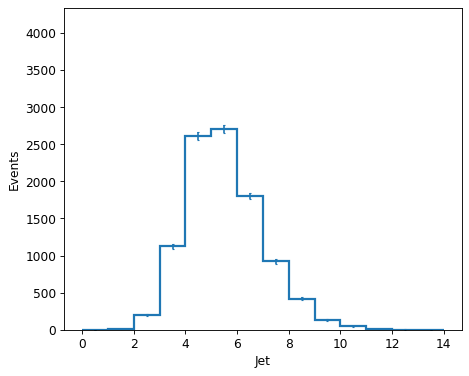

In [5]:
study.quick(
    [tree],
    varlist=['Jet'],
    lumi=None,
)

In [6]:
tree.Particle_M1[0], tree.Particle_M2[0]

(<Array [5, 5, 6, 0, ... 1371, 1371, 1373, 1373] type='1386 * int32'>,
 <Array [-1, -1, -1, 2, 2, ... -1, -1, -1, -1] type='1386 * int32'>)

In [152]:
def get_gen_hh4b(tree):
    genparts = ak.zip(dict(
        pt=tree.Particle_PT,
        eta=tree.Particle_Eta,
        phi=tree.Particle_Phi,
        mass=tree.Particle_Mass,
        pid=tree.Particle_PID,
        status=tree.Particle_Status,
        mother=tree.Particle_M1,
    ), with_name='Momentum4D')

    is_b = abs(genparts.pid) == 5
    outgoing = genparts.status == 23
    bquarks= genparts[is_b & outgoing]
    higgs = genparts[bquarks.mother]

    bquark_pt_rank = ak_rank(bquarks.pt, axis=1)
    bquark_pt_rank, bquarks.pt
    higgs_pt_norm = (higgs.pt - ak.min(higgs.pt,axis=1)) / (ak.max(higgs.pt, axis=1) - ak.min(higgs.pt, axis=1))
    bquark_reco_rank = 10 * higgs_pt_norm + bquark_pt_rank

    bquarks = bquarks[ak.argsort(-bquark_reco_rank, axis=1)]
    higgs = genparts[bquarks.mother[:,::2]]

    return bquarks, higgs
    

In [218]:
bquarks, higgs = get_gen_hh4b(tree)
genjets = ak.zip(dict(
    pt=tree.GenJet_PT,
    eta=tree.GenJet_Eta,
    phi=tree.GenJet_Phi,
    mass=tree.GenJet_Mass,
), with_name='Momentum4D')
recojets = ak.zip(dict(
    pt=tree.Jet_PT,
    eta=tree.Jet_Eta,
    phi=tree.Jet_Phi,
    mass=tree.Jet_Mass,
), with_name='Momentum4D')

In [223]:
def dr_match_objs_no_duplicates(obj1_p4, obj2_p4):
    n_obj1 = ak.num(obj1_p4, axis=1)
    n_obj2 = ak.num(obj2_p4, axis=1)

    obj1_obj2_dr = ak.flatten(obj1_p4.deltaR(obj2_p4[:,None]), axis=2)
    obj1_obj2_index = ak.local_index(obj1_obj2_dr)
    mask = ak.ones_like(obj1_obj2_dr, dtype=bool)

    niters = ak.max(ak.min(ak.concatenate([n_obj1[:,None], n_obj2[:,None]], axis=1), axis=1))

    obj1_index = ak.local_index(obj1_p4.pt)
    obj1_matched_dr = -ak.ones_like(obj1_p4.pt)
    obj1_matched_idx = -ak.ones_like(obj1_p4.pt, dtype=int)

    obj2_index = ak.local_index(obj2_p4.pt)
    obj2_matched_dr = -ak.ones_like(obj2_p4.pt)
    obj2_matched_idx = -ak.ones_like(obj2_p4.pt,  dtype=int)

    for _ in range(niters):
        masked_obj1_obj2_dr = ak.where(mask, obj1_obj2_dr, 999)
        mindr, argmin = ak.min(masked_obj1_obj2_dr, axis=1), ak.argmin(masked_obj1_obj2_dr, axis=1)

        matched_obj1_idx = argmin % n_obj1
        matched_obj2_idx = argmin // n_obj1

        matched_obj1_idx = ak.where(mindr == 999, -1, matched_obj1_idx)
        matched_obj2_idx = ak.where(mindr == 999, -1, matched_obj2_idx)
        mindr = ak.where(mindr == 999, -1, mindr)

        obj1_matched_dr = ak.where( (obj1_index == matched_obj1_idx) & (obj1_matched_dr == -1), mindr, obj1_matched_dr )
        obj1_matched_idx = ak.where( (obj1_index == matched_obj1_idx) & (obj1_matched_idx == -1), matched_obj2_idx, obj1_matched_idx )

        obj2_matched_dr = ak.where( (obj2_index == matched_obj2_idx) & (obj2_matched_dr == -1), mindr, obj2_matched_dr )
        obj2_matched_idx = ak.where( (obj2_index == matched_obj2_idx) & (obj2_matched_idx == -1), matched_obj1_idx, obj2_matched_idx )

        mask = mask & ~( ( (obj1_obj2_index % n_obj1) == matched_obj1_idx ) | ( (obj1_obj2_index // n_obj1) == matched_obj2_idx ) )

    obj1_matched_dr = ak.fill_none(obj1_matched_dr, -1, axis=None)
    obj1_matched_idx = ak.fill_none(obj1_matched_idx, -1, axis=None)

    obj2_matched_dr = ak.fill_none(obj2_matched_dr, -1, axis=None)
    obj2_matched_idx = ak.fill_none(obj2_matched_idx, -1, axis=None)

    return obj1_matched_dr, obj1_matched_idx, obj2_matched_dr, obj2_matched_idx

In [251]:
bquarks['matched_genjet_dr'], bquarks['matched_genjet_idx'], genjets['matched_bquark_dr'], genjets['matched_bquark_idx'] = dr_match_objs_no_duplicates(bquarks, genjets)
genjets['matched_recojet_dr'], genjets['matched_recojet_idx'], recojets['matched_genjet_dr'], recojets['matched_genjet_idx'] = dr_match_objs_no_duplicates(genjets, recojets)

In [256]:
matched_recojet_genjet = (recojets.matched_genjet_dr > 0) & (recojets.matched_genjet_dr < 0.4)
matched_genjet_bquark = (genjets.matched_bquark_dr > 0) & (genjets.matched_bquark_dr < 0.4)

In [260]:
matched_genjet_bquark[recojets.matched_genjet_idx] & matched_recojet_genjet

<Array [[False, False, False, ... True, True]] type='10000 * var * bool'>

In [214]:
def gen_match_hh4b(tree):
    bquarks, higgs = get_gen_hh4b(tree)

    fields = ['pt', 'eta', 'phi', 'mass']
    branches = dict()

    quarks = ['h1b1','h1b2','h2b1','h2b2']
    for i, quark in enumerate(quarks):
        for field in fields:
            branches[f'genpart_{quark}_{field}'] = bquarks[field][:,i]

    for i, h in enumerate(['h1','h2']):
        for field in fields:
            branches[f'genpart_{h}_{field}'] = higgs[field][:,i]

    genjets = ak.zip(dict(
        pt=tree.GenJet_PT,
        eta=tree.GenJet_Eta,
        phi=tree.GenJet_Phi,
        mass=tree.GenJet_Mass,
    ), with_name='Momentum4D')
    
    bquarks['matched_genjet_dr'], bquarks['matched_genjet_idx'], genjets['matched_bquark_dr'], genjets['matched_bquark_idx'] = dr_match_objs_no_duplicates(bquarks, genjets)

    for i, quark in enumerate(quarks):
        quark_genjet = ak.firsts(genjets[genjets.matched_bquark_idx == 0], axis=1)
        for field in fields + ['matched_bquark_dr']:
            branches[f'genjet_{quark}_{field}'] = ak.fill_none(quark_genjet[field], -999)

    recojets = ak.zip(dict(
        pt=tree.Jet_PT,
        eta=tree.Jet_Eta,
        phi=tree.Jet_Phi,
        mass=tree.Jet_Mass,
        btag=tree.Jet_BTag,
    ), with_name='Momentum4D')
    genjets['matched_recojet_dr'], genjets['matched_recojet_idx'], recojets['matched_genjet_dr'], recojets['matched_genjet_idx'] = dr_match_objs_no_duplicates(genjets, recojets)
    branches['Jet_Matched_GenJet_DR'] = recojets.matched_genjet_dr

    tree.extend(**branches)

In [216]:
gen_match_hh4b(tree)

100%|██████████| 1/1 [00:00<00:00, 22.64it/s]


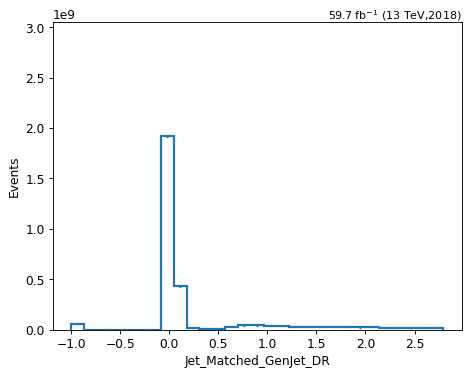

In [217]:
study.quick(
    [tree],
    varlist=['Jet_Matched_GenJet_DR']
)

100%|██████████| 4/4 [00:00<00:00, 29.60it/s]


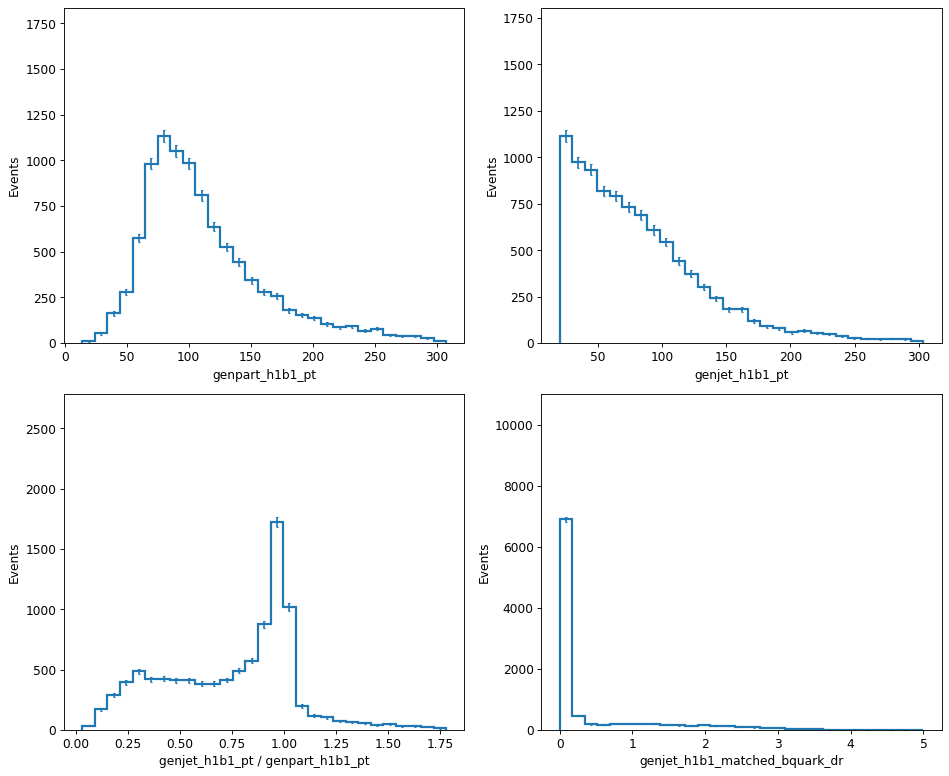

In [109]:
study.quick(
    [tree],
    masks='genjet_h1b1_pt > 0',
    varlist=['genpart_h1b1_pt','genjet_h1b1_pt', 'genjet_h1b1_pt / genpart_h1b1_pt','genjet_h1b1_matched_bquark_dr'],
    lumi=None,
)